In [62]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [64]:
def gaussian_nll_loss(target, predicted_mean, predicted_var_diag):
    """ Vypočítá Gaussian Negative Log Likelihood. """
    # Přidáme malou konstantu pro numerickou stabilitu
    predicted_var_diag = predicted_var_diag + 1e-6
    
    # Výpočet log determinantu (pro diagonální matici je to součet logaritmů)
    log_det_cov = torch.sum(torch.log(predicted_var_diag), dim=-1)
    
    # Výpočet Mahalanobisovy vzdálenosti
    diff = target - predicted_mean
    mahalanobis_sq = torch.sum((diff**2) / predicted_var_diag, dim=-1)
    
    # Spojení do NLL
    element_wise_nll = 0.5 * (log_det_cov + mahalanobis_sq)
    
    # Zprůměrování přes dávku a čas
    return torch.mean(element_wise_nll)

In [65]:
import torch
from torch.func import jacrev

class ExtendedKalmanFilter:
    def __init__(self, system_model):

        self.device = system_model.Q.device

        self.f = system_model.f
        self.h = system_model.h

        # Pokud je systém lineární, Jakobiány jsou konstantní matice F a H
        self.is_linear_f = getattr(system_model, 'is_linear_f', False)
        self.is_linear_h = getattr(system_model, 'is_linear_h', False)
        if self.is_linear_f:
            self.F = system_model.F
        if self.is_linear_h:
            self.H = system_model.H


        self.Q = system_model.Q.clone().detach().to(self.device)
        self.R = system_model.R.clone().detach().to(self.device)

        self.state_dim = self.Q.shape[0]
        self.obs_dim = self.R.shape[0]

        self.x_filtered_prev = None
        self.P_filtered_prev = None

        self.reset(system_model.Ex0, system_model.P0)

    def reset(self, Ex0=None, P0=None):
        """
        Inicializuje nebo resetuje stav filtru.
        """
        if Ex0 is not None:
            # Ujistíme se, že má správný tvar [dim, 1]
            self.x_filtered_prev = Ex0.clone().detach().reshape(self.state_dim, 1)
        if P0 is not None:
            self.P_filtered_prev = P0.clone().detach()

    def predict_step(self, x_filtered, P_filtered):
        if self.is_linear_f:
            F_t = self.F
        else:
            F_t = jacrev(self.f)(x_filtered.squeeze()).reshape(self.state_dim, self.state_dim)

        x_predict = self.f(x_filtered)
        P_predict = F_t @ P_filtered @ F_t.T + self.Q
        return x_predict, P_predict

    def update_step(self, x_predict, y_t, P_predict):
        y_t = y_t.reshape(self.obs_dim, 1)

        if self.is_linear_h:
            H_t = self.H
        else:
            H_t = jacrev(self.h)(x_predict.squeeze()).reshape(self.obs_dim, self.state_dim)

        innovation = y_t - self.h(x_predict)
        S = H_t @ P_predict @ H_t.T + self.R
        K = P_predict @ H_t.T @ torch.linalg.inv(S)
        x_filtered = x_predict + K @ innovation


        I = torch.eye(self.state_dim, device=self.device)
        P_filtered = (I - K @ H_t) @ P_predict @ (I - K @ H_t).T + K @ self.R @ K.T

        return x_filtered, P_filtered, K, innovation

    def step(self, y_t):
        """
        Provede jeden kompletní krok filtrace (predict + update) pro online použití.
        """
        # 1. Predikce z uloženého interního stavu
        x_predict, P_predict = self.predict_step(self.x_filtered_prev, self.P_filtered_prev)

        # 2. Update s novým měřením
        x_filtered, P_filtered = self.update_step(x_predict, y_t, P_predict)

        # 3. Aktualizace interního stavu pro další volání
        self.x_filtered_prev = x_filtered
        self.P_filtered_prev = P_filtered

        return x_filtered, P_filtered

    def process_sequence(self, y_seq, Ex0=None, P0=None):
            """
            Zpracuje celou sekvenci měření `y_seq` (offline) a vrátí detailní historii.
            """
            # Pokud nejsou zadány, použije defaultní hodnoty z `__init__`
            x_est = Ex0.clone().detach().reshape(self.state_dim, 1) if Ex0 is not None else self.x_filtered_prev.clone()
            P_est = P0.clone().detach() if P0 is not None else self.P_filtered_prev.clone()

            seq_len = y_seq.shape[0]

            x_filtered_history = torch.zeros(seq_len, self.state_dim, device=self.device)
            P_filtered_history = torch.zeros(seq_len, self.state_dim, self.state_dim, device=self.device)
            x_predict_history = torch.zeros(seq_len, self.state_dim, device=self.device)
            P_predict_history = torch.zeros(seq_len, self.state_dim, self.state_dim, device=self.device)
            kalman_gain_history = torch.zeros(seq_len, self.state_dim, self.obs_dim, device=self.device)
            innovation_history = torch.zeros(seq_len, self.obs_dim, device=self.device)

            for t in range(seq_len):
                # 1. Predict
                x_predict, P_predict = self.predict_step(x_est, P_est)

                # 2. Update
                x_est, P_est, K, innovation = self.update_step(x_predict, y_seq[t], P_predict)

                x_filtered_history[t] = x_est.squeeze()
                P_filtered_history[t] = P_est
                x_predict_history[t] = x_predict.squeeze()
                P_predict_history[t] = P_predict
                kalman_gain_history[t] = K
                innovation_history[t] = innovation.squeeze()

            return {
                'x_filtered': x_filtered_history,
                'P_filtered': P_filtered_history,
                'x_predict': x_predict_history,
                'P_predict': P_predict_history,
                'Kalman_gain': kalman_gain_history,
                'innovation': innovation_history
            }

In [66]:
import torch

class DynamicSystem:
    # ... __init__ zůstává stejný ...
    def __init__(self, state_dim, obs_dim, Q, R, Ex0, P0, f=None, h=None, F=None, H=None, device=None):
        if device is None: self.device = Q.device
        else: self.device = device
        self.state_dim, self.obs_dim = state_dim, obs_dim
        self.Q, self.R, self.Ex0, self.P0 = Q.to(self.device), R.to(self.device), Ex0.to(self.device), P0.to(self.device)
        if f is not None and F is not None: raise ValueError("Zadejte buď `f` nebo `F`.")
        if h is not None and H is not None: raise ValueError("Zadejte buď `h` nebo `H`.")
        self._f_func, self._h_func = f, h
        self.F = F.to(self.device) if F is not None else None
        self.H = H.to(self.device) if H is not None else None
        self.is_linear_f, self.is_linear_h = (self.F is not None), (self.H is not None)
        if not self.is_linear_f and self._f_func is None: raise ValueError("Chybí `f` nebo `F`.")
        if not self.is_linear_h and self._h_func is None: raise ValueError("Chybí `h` nebo `H`.")
        try:
            self.L_q, self.L_r, self.L_p0 = torch.linalg.cholesky(self.Q), torch.linalg.cholesky(self.R), torch.linalg.cholesky(self.P0)
        except torch.linalg.LinAlgError as e:
            print(f"Varování při Choleského rozkladu: {e}")

    def f(self, x_in):
        if x_in.dim() == 1: x_in = x_in.unsqueeze(0)
        batch_size = x_in.shape[0]
        x_batch = x_in.unsqueeze(-1)
        if self.is_linear_f:
            F_batch = self.F.unsqueeze(0).expand(batch_size, -1, -1)
            return torch.bmm(F_batch, x_batch).squeeze(-1)
        else:
            res = [self._f_func(x_batch[i]) for i in range(batch_size)]
            return torch.stack(res).squeeze(-1)

    def h(self, x_in):
        if x_in.dim() == 1: x_in = x_in.unsqueeze(0)
        batch_size = x_in.shape[0]
        x_batch = x_in.unsqueeze(-1)
        if self.is_linear_h:
            H_batch = self.H.unsqueeze(0).expand(batch_size, -1, -1)
            return torch.bmm(H_batch, x_batch).squeeze(-1)
        else:
            res = [self._h_func(x_batch[i]) for i in range(batch_size)]
            return torch.stack(res).squeeze(-1)

    def get_initial_state(self):
        z = torch.randn(self.state_dim, 1, device=self.device)
        return (self.Ex0 + self.L_p0 @ z).squeeze(-1)

    def get_deterministic_initial_state(self):
        return self.Ex0.clone().squeeze(-1)

    def step(self, x_prev_in):
        """Provede jeden krok dynamiky. Vstup i výstup jsou 2D: [B, D]."""
        if x_prev_in.dim() == 1:
            x_prev_in = x_prev_in.unsqueeze(0)

        batch_size = x_prev_in.shape[0]
        w = self.L_q @ torch.randn(batch_size, self.state_dim, 1, device=self.device)
        return self.f(x_prev_in) + w.squeeze(-1)

    def measure(self, x_in):
        """Provede měření stavu. Vstup i výstup jsou 2D: [B, D] a [B, O]."""
        if x_in.dim() == 1:
            x_in = x_in.unsqueeze(0)

        batch_size = x_in.shape[0]
        v = self.L_r @ torch.randn(batch_size, self.obs_dim, 1, device=self.device)
        y_noiseless = self.h(x_in)
        return y_noiseless + v.squeeze(-1)

In [67]:
from torch import nn
import torch

class ConcreteDropout(nn.Module):
    def __init__(self, weight_regularizer=1e-6, dropout_regularizer=1e-6, init_min=0.5, init_max=0.8,device=None):
        """
        weight_regularizer: váha regularizace vah - ve článku je to l^2
        dropout_regularizer: váha regularizace dropout pravděpodobnosti - ve článku je to K
        """
        super(ConcreteDropout, self).__init__()
        # self.device = device
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer

        init_min = torch.log(torch.tensor(init_min)) - torch.log(1. - torch.tensor(init_min))
        init_max = torch.log(torch.tensor(init_max)) - torch.log(1. - torch.tensor(init_max))

        self.p_logit = nn.Parameter(torch.empty(1).uniform_(init_min, init_max)) # dropout prob p je trenovatelny parametr,
        #uniform zajisti, ze je vzdy mezi 0 a 1
        # "logit" je transformace pravdepodobnosti p na realnou osu, tedy misto toho, aby se neuronka ucila, ze p musi byt mezi 0 a 1
        # , ucime se p_logit, ktery muze byt libovolne realne cislo

    def forward(self, x, layer):
        p = torch.sigmoid(self.p_logit.to(x.device)) # p je mezi 0 a 1

        x_dropped = self._concrete_dropout(x, p)
        out = layer(x_dropped)

        sum_of_squares = 0
        for param in layer.parameters():
            sum_of_squares += torch.sum(torch.pow(param, 2))

        weights_regularizer = self.weight_regularizer * sum_of_squares / (1. - p)

        dropout_regularizer = p * torch.log(p)
        dropout_regularizer += (1. - p) * torch.log(1. - p)

        input_dim = x[0].numel()
        dropout_regularizer *= self.dropout_regularizer * input_dim

        regularization = weights_regularizer + dropout_regularizer

        return out, regularization

    def _concrete_dropout(self, x, p):
        """
        Applies Concrete Dropout to the input tensor x.
        """
        eps = 1e-7
        t = 0.1

        unif_noise = torch.rand_like(x) # ve clanku je to parametr u - U(0,1)

        drop_prob = (torch.log(p+eps) - torch.log(1. - p+eps) + torch.log(unif_noise+eps) - torch.log(1. - unif_noise+eps))
        drop_prob = torch.sigmoid(drop_prob / t) # pravdepodobnost vypnuti neuronu

        random_tensor = 1. - drop_prob
        retain_prob = 1. - p # pravdepodobnost, ze neuron zustane aktivni

        x= torch.mul(x, random_tensor) # vektor, ktery reprezentuje dropout masku, zpusobi ztlumeni neuronu, misto jejich uplneho vypnuti
        x = x / retain_prob # aplikace inverzniho skalovani

        return x


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class DNN_BayesianKalmanNet(nn.Module):
    def __init__(self, system_model, hidden_size_multiplier=10, output_layer_multiplier=4, num_gru_layers=1,init_min_dropout=0.5,init_max_dropout=0.8):
        super(DNN_BayesianKalmanNet, self).__init__()

        self.state_dim = system_model.state_dim
        self.obs_dim = system_model.obs_dim
        self.device = system_model.device

        self.input_dim = 2 * self.state_dim + 2 * self.obs_dim
        self.output_dim = self.state_dim * self.obs_dim

        self.H1 = (self.state_dim + self.obs_dim) * hidden_size_multiplier * 8
        self.H2 = (self.state_dim * self.obs_dim) * output_layer_multiplier * 1

        # Přidání LayerNorm pro stabilizaci vstupů
        self.input_norm = nn.LayerNorm(self.input_dim)

        self.input_layer = nn.Sequential(
            nn.Linear(self.input_dim, self.H1),
            nn.ReLU()
        )
        self.concrete_dropout1 = ConcreteDropout(device=self.device, init_min=init_min_dropout, init_max=init_max_dropout)

        gru_hidden_dim = 4 * ((self.state_dim * self.state_dim) + (self.obs_dim * self.obs_dim))

        self.gru = nn.GRU(self.H1, gru_hidden_dim, num_layers=num_gru_layers)

        self.output_layer = nn.Sequential(
            nn.Linear(gru_hidden_dim, self.H2),
            nn.ReLU(),
            nn.Linear(self.H2, self.output_dim, bias=True)
        )
        self.concrete_dropout2 = ConcreteDropout(device=self.device, init_min=init_min_dropout, init_max=init_max_dropout)

    def forward(self, state_inno, inovation, diff_state, diff_obs, h_prev):

        nn_input = torch.cat([state_inno, inovation, diff_state, diff_obs], dim=1)

        # Aplikace normalizace
        normalized_input = self.input_norm(nn_input)

        # Dropout se aplikuje na normalizovaná data
        activated_input, reg1 = self.concrete_dropout1(normalized_input, self.input_layer)

        out_gru, h_new = self.gru(activated_input.unsqueeze(0), h_prev)
        out_gru_squeezed = out_gru.squeeze(0)

        out_final, reg2 = self.concrete_dropout2(out_gru_squeezed, self.output_layer)

        total_reg = reg1+reg2
        return out_final, h_new, total_reg

In [69]:
class StateBayesianKalmanNet(nn.Module):
    def __init__(self,system_model, device, hidden_size_multiplier=10, output_layer_multiplier=4, num_gru_layers=1,init_min_dropout=0.5,init_max_dropout=0.8):
        super(StateBayesianKalmanNet, self).__init__()

        self.device = device
        self.system_model = system_model
        self.state_dim = system_model.state_dim
        self.obs_dim = system_model.obs_dim
        self.num_gru_layers = num_gru_layers

        self.dnn = DNN_BayesianKalmanNet(system_model, hidden_size_multiplier, output_layer_multiplier, num_gru_layers, init_min_dropout, init_max_dropout).to(device)

        self.h_init_master = torch.randn(
            self.dnn.gru.num_layers, 
            1, # pro batch_size=1
            self.dnn.gru.hidden_size, 
            device=self.device
        ).detach()

        self.x_filtered_prev = None
        self.x_filtered_prev_prev = None
        self.x_pred_prev = None
        self.y_prev = None
        self.h_prev_ensemble = None 
        self.is_first_step = True
        self.reset()

    def reset(self, batch_size=1, initial_state=None):
        """
        Finální, robustní a jednoduchý reset.
        Připraví model na zpracování dávky o velikosti `batch_size`.
        """
        if initial_state is not None:
            self.x_filtered_prev = initial_state.detach().clone()
        else:
            self.x_filtered_prev = torch.zeros(batch_size, self.state_dim, device=self.device)
            
        self.is_first_step = True
        
        # ZMĚNA: Skrytý stav se neuchovává pro J realizací.
        # Ten se vytvoří až v prvním kroku v metodě step().
        # self.h_prev bude nyní sloužit jen pro predikci v prvním kroku.
        self.h_prev = self.h_init_master.expand(-1, batch_size, -1).clone()

    def step(self, y_t, J_samples=20):
        """
        Finální, plně vektorizovaná a zjednodušená krokovací metoda.
        Zpracuje jednu dávku `y_t` o velikosti `B`.
        """
        batch_size = y_t.shape[0]
        num_layers = self.dnn.gru.num_layers


        # Predikce (plně vektorizovaná)
        x_predicted = self.system_model.f(self.x_filtered_prev)
        
        if self.is_first_step:
            # V prvním kroku nastavíme historické stavy tak, aby rozdíly byly nulové
            self.x_filtered_prev_prev = self.x_filtered_prev.clone()
            self.x_pred_prev = x_predicted.clone()
            self.y_prev = self.system_model.h(x_predicted)
            self.h_prev_ensemble = self.h_init_master.expand(-1, batch_size * J_samples, -1).clone()

        y_predicted = self.system_model.h(x_predicted)

        # Ošetření pro 1D případ, kde squeeze může odstranit dávkovou dimenzi
        if y_predicted.dim() == 1: y_predicted = y_predicted.unsqueeze(-1)
        if y_t.dim() == 1: y_t = y_t.unsqueeze(-1)

        # Výpočet vstupních příznaků pro DNN
        state_inno = self.x_filtered_prev - self.x_pred_prev
        inovation = y_t - y_predicted
        diff_state = self.x_filtered_prev - self.x_filtered_prev_prev
        diff_obs = y_t - self.y_prev

        state_inno_J = state_inno.repeat_interleave(J_samples, dim=0)
        inovation_J = inovation.repeat_interleave(J_samples, dim=0)
        diff_state_J = diff_state.repeat_interleave(J_samples, dim=0)
        diff_obs_J = diff_obs.repeat_interleave(J_samples, dim=0)
        
        # JEDEN dopředný průchod pro celý ansámbl
        # Použijeme ansámbl skrytých stavů z minulého kroku
        K_vec_J, h_new_ensemble, total_reg = self.dnn(state_inno_J, inovation_J, diff_state_J, diff_obs_J, self.h_prev_ensemble)
        
        # Predikovaný stav také potřebuje J kopií pro korekci
        x_predicted_J = x_predicted.repeat_interleave(J_samples, dim=0)
        
        # Provedeme J korekcí najednou
        K_J = K_vec_J.reshape(-1, self.state_dim, self.obs_dim)
        correction_J = torch.bmm(K_J, inovation_J.unsqueeze(-1)).squeeze(-1)
        x_filtered_J = x_predicted_J + correction_J
        # Přetvarujeme výsledky zpět, abychom oddělili dávku od J vzorků
        # (B * J, state_dim) -> (B, J, state_dim)
        x_filtered_ensemble = x_filtered_J.view(batch_size, J_samples, self.state_dim)
        
        final_x_filtered = x_filtered_ensemble.mean(dim=1)
        final_P_filtered_diag = x_filtered_ensemble.var(dim=1)
        # Zprůměrujeme také regularizaci
        # --- NOVÉ ZPRACOVÁNÍ REGULARIZACE ---
        # regs_J_list je seznam tenzorů, např. 2x (B*J,)
        # Spojíme je do tenzoru o tvaru [num_layers, B*J]
        # regs_J_tensor = torch.stack(regs_J_list)
        
        # # Přetvarujeme na [num_layers, B, J]
        # regs_J_tensor_reshaped = regs_J_tensor.view(len(regs_J_list), batch_size, J_samples)
        
        # # Zprůměrujeme POUZE přes J vzorky (dim=2)
        # # Výsledkem je tenzor [num_layers, B]
        # regularization_per_layer_and_sample = regs_J_tensor_reshaped.mean(dim=2)
        
        # # Transponujeme na [B, num_layers] pro snazší zpracování v trénovací smyčce
        # regularization_for_step = regularization_per_layer_and_sample.transpose(0, 1)
        
        regularization_for_step = total_reg
        # 5. AKTUALIZACE STAVŮ PRO DALŠÍ KROK
        self.x_pred_prev = x_predicted.detach()
        self.x_filtered_prev_prev = self.x_filtered_prev.clone().detach()
        self.y_prev = y_t.clone().detach()
        
        # Uložíme zprůměrovaný výsledek pro příští predikci
        self.x_filtered_prev = final_x_filtered.clone().detach()
        # A uložíme si kompletní ansámbl nových skrytých stavů pro příští krok
        self.h_prev_ensemble = h_new_ensemble.clone().detach()
        
        self.is_first_step = False

        # Vrátíme finální odhad, jeho nejistotu a regularizaci
        return final_x_filtered, final_P_filtered_diag, regularization_for_step, x_filtered_ensemble

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

# =================================================================================
# 1. POMOCNÉ FUNKCE
# =================================================================================

def generate_data(system, num_trajectories, seq_len):
    """Generuje data (trajektorie) pro daný dynamický systém."""
    device = system.Ex0.device
    x_data = torch.zeros(num_trajectories, seq_len, system.state_dim, device=device)
    y_data = torch.zeros(num_trajectories, seq_len, system.obs_dim, device=device)

    for i in range(num_trajectories):
        x = system.get_initial_state() # Vrací 1D tenzor, např. shape [1]

        for t in range(seq_len):
            if t > 0:
                # `step` nyní očekává dávku, takže x předáme jako dávku o velikosti 1
                x = system.step(x.unsqueeze(0)).squeeze(0)

            # `measure` také očekává dávku
            y = system.measure(x.unsqueeze(0)).squeeze(0)

            x_data[i, t, :] = x
            y_data[i, t, :] = y

    return x_data, y_data

def store_model(model, path):
    """Uloží stav modelu do souboru."""
    torch.save(model.state_dict(), path)
    print(f"Model byl uložen do {path}")

def calculate_anees(true_states_list, est_states_list, est_covs_list):
    """
    Vypočítá Average Normalized Estimation Error Squared (ANEES).
    Očekává, že všechny vstupní tenzory jsou na CPU pro výpočet.
    """
    all_nees = []
    with torch.no_grad():
        for x_true, x_hat, P_hat in zip(true_states_list, est_states_list, est_covs_list):
            seq_len, state_dim = x_true.shape
            # Jitter pro numerickou stabilitu inverze
            jitter = torch.eye(state_dim, device=P_hat.device) * 1e-9
            for t in range(seq_len):
                error = (x_true[t] - x_hat[t]).unsqueeze(1)
                P_t = P_hat[t]
                try:
                    P_inv = torch.inverse(P_t + jitter)
                    nees_t = (error.transpose(0, 1) @ P_inv @ error).item()
                    all_nees.append(nees_t)
                except torch.linalg.LinAlgError:
                    # Stane se, pokud je matice singulární i po přidání jitteru
                    continue
    if not all_nees:
        return float('inf') # Není-li možné vypočítat žádný NEES
    return sum(all_nees) / len(all_nees)

def authors_empirical_loss_detached(target, predicted_mean, predicted_var, beta):
    """
    Teoreticky čistší verze loss funkce, která odděluje gradienty pro mean a var.
    """
    # L1 Loss: MSE (průměr) pro přesnost odhadu střední hodnoty
    l1_loss_mean = F.mse_loss(predicted_mean, target)

    # L2 Loss: Chyba odhadu variance (součet)
    # Použití .detach() zajistí, že gradient z L2 neovlivňuje váhy pro 'predicted_mean'.
    with torch.no_grad():
        empirical_variance = (target - predicted_mean)**2

    l2_loss_sum = torch.sum(torch.abs(predicted_var - empirical_variance.detach()))

    l2_loss_mean = torch.mean(torch.abs(predicted_var - empirical_variance.detach()))
    # Celková datová ztráta
    total_data_loss = (1 - beta) * l1_loss_mean + beta * l2_loss_mean

    # Pro účely logování vrátíme i zprůměrovanou verzi l2_loss
    with torch.no_grad():
        l2_loss_mean = torch.mean(torch.abs(predicted_var - empirical_variance))

    return total_data_loss, l1_loss_mean, l2_loss_mean




In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy


def run_training_session(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period, final_beta, scheduler_step_size, gamma_value
):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=scheduler_step_size, gamma=gamma_value)
    # Sledování nejlepších výsledků (nyní ukládáme podle ANEES)
    best_val_anees = float('inf')
    loss_at_best_anees = float('inf')
    mse_at_best_anees = float('inf')
    best_iter_count = 0
    best_model_state = None

    train_iter_count = 0
    done = False

    while not done:
        model.train() # Ujistíme se, že jsme v trénovacím módu (dropout je aktivní)
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter:
                done = True
                break

            # --- Tréninkový krok ---
            optimizer.zero_grad()
            batch_size, seq_len, state_dim = x_true_batch.shape

            # Reset filtru pro novou dávku
            initial_state = x_true_batch[:, 0, :]
            model.reset(batch_size=batch_size, initial_state=initial_state)

            # Seznamy pro sběr výsledků v čase
            all_x_hats = []
            all_cov_hats_diag = []
            all_regs = []

            # Smyčka přes časovou sekvenci
            for t in range(1, seq_len):
                y_t = y_meas_batch[:, t, :]
                x_filtered_t, cov_filtered_diag_t, reg_t,_ = model.step(y_t, J_samples=J_samples)
                
                all_x_hats.append(x_filtered_t)
                all_cov_hats_diag.append(cov_filtered_diag_t)
                all_regs.append(reg_t)

            # Spojení výsledků ze všech časových kroků do jednoho tenzoru
            x_hat_sequence = torch.stack(all_x_hats, dim=1)
            cov_hat_diag_sequence = torch.stack(all_cov_hats_diag, dim=1)
            regularization_sequence_tensor = torch.stack(all_regs, dim=0)
            # Nyní sečteme přes VŠECHNY dimenze (čas, dávka, vrstvy), abychom dostali jeden skalár.
            regularization_loss = torch.sum(regularization_sequence_tensor)

            # Výpočet datové ztráty
            target_sequence = x_true_batch[:, 1:, :]
            target_sequence = x_true_batch[:, 1:, :]
            nll_loss = gaussian_nll_loss(target_sequence, x_hat_sequence, cov_hat_diag_sequence)
            # Celková ztráta
            loss = nll_loss + regularization_loss

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"!!! Kolaps v iteraci {train_iter_count}, ztráta je NaN/Inf. Ukončuji. !!!")
                done = True
                break

            loss.backward()
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            scheduler.step()
            train_iter_count += 1

            # Logování tréninku
            if train_iter_count % logging_period == 0:
                with torch.no_grad():
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                    current_lr = scheduler.get_last_lr()[0]

                print(f"--- Iteration [{train_iter_count}/{total_train_iter}] ---")
                print(f"  Overall Loss: {loss.item():.4f}")
                # print(f"    - MSE Loss (L1 part):      {mse_component.item():.4f}")
                # print(f"    - Variance Loss (L2 part): {var_loss_component.item():.4f}")
                print(f"    - Dropout Regularization:  {regularization_loss.item():.4f}")
                # print(f"    - Beta weight for L2:      {beta:.4f}")
                print(f"  Dropout Probs: p1={p1:.3f}, p2={p2:.3f}")
                print(f"  Current Learning Rate: {current_lr:.2e}")
                print("-" * 25)

            # --- Validační krok ---
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                print(f"\n--- Validace v iteraci {train_iter_count} ---")
                model.train() # I během validace chceme dropout aktivní pro ansámbl

                val_x_true_list, val_x_hat_list, val_P_hat_list = [], [], []
                val_loss_list = []
                val_mse_list = []

                with torch.no_grad():
                    for x_true_val_batch, y_meas_val_batch in val_loader:
                        val_batch_size, val_seq_len, _ = x_true_val_batch.shape
                        
                        model.reset(batch_size=val_batch_size, initial_state=x_true_val_batch[:, 0, :])

                        val_all_x_hats_seq = []
                        val_all_cov_hats_diag_seq = []
                        val_all_regs_seq = []
                        
                        # Uchováme si celý ansámbl pro výpočet plné kovariance
                        val_full_ensemble_seq = [] 

                        for t in range(1, val_seq_len):
                            y_t_val = y_meas_val_batch[:, t, :]
                            # Úprava: metoda step nyní vrací i celý ansámbl pro výpočet plné P
                            x_filtered_t, cov_diag_t, reg_t, full_ensemble_t = model.step(y_t_val, J_samples=J_samples)
                            
                            val_all_x_hats_seq.append(x_filtered_t)
                            val_all_cov_hats_diag_seq.append(cov_diag_t)
                            val_all_regs_seq.append(reg_t)
                            val_full_ensemble_seq.append(full_ensemble_t)

                        val_predictions_seq = torch.stack(val_all_x_hats_seq, dim=1)
                        val_covariances_diag_seq = torch.stack(val_all_cov_hats_diag_seq, dim=1)
                        val_regularization_loss = torch.stack(val_all_regs_seq).mean()
                        val_full_ensemble = torch.stack(val_full_ensemble_seq, dim=2) # Tvar: (B, J, T-1, D)

                        val_target_sequence = x_true_val_batch[:, 1:, :]

                        val_data_loss = gaussian_nll_loss(val_target_sequence, val_predictions_seq, val_covariances_diag_seq)
                        val_loss_list.append((val_data_loss + val_regularization_loss).item())
                        val_mse_list.append(F.mse_loss(val_predictions_seq, val_target_sequence).item())

                        # Přidání počátečního stavu pro ANEES
                        initial_states_batch = x_true_val_batch[:, 0, :].unsqueeze(1)
                        full_x_hat_batch = torch.cat([initial_states_batch, val_predictions_seq], dim=1)

                        # Výpočet plné kovarianční matice z ansámblu
                        diff_val = val_full_ensemble - val_predictions_seq.unsqueeze(1) # B, J, T-1, D
                        diff_val_permuted = diff_val.permute(0, 2, 1, 3) # B, T-1, J, D
                        outer_products = diff_val_permuted.unsqueeze(-1) @ diff_val_permuted.unsqueeze(-2) # B, T-1, J, D, D
                        val_covariances_full_batch = outer_products.mean(dim=2) # B, T-1, D, D
                        
                        P0_val = model.system_model.P0 # Předpoklad, že P0 je definováno v system_model
                        P0_batch = P0_val.unsqueeze(0).repeat(val_batch_size, 1, 1)
                        full_P_hat_batch = torch.cat([P0_batch.unsqueeze(1), val_covariances_full_batch], dim=1)

                        # Převod na CPU pro výpočet ANEES
                        for i in range(val_batch_size):
                            val_x_true_list.append(x_true_val_batch[i].cpu())
                            val_x_hat_list.append(full_x_hat_batch[i].cpu())
                            val_P_hat_list.append(full_P_hat_batch[i].cpu())

                avg_val_loss = np.mean(val_loss_list)
                avg_val_mse = np.mean(val_mse_list)
                avg_val_anees = calculate_anees(val_x_true_list, val_x_hat_list, val_P_hat_list)

                print(f"  Průměrná validační Loss: {avg_val_loss:.4f}")
                print(f"  Průměrné validační MSE:  {avg_val_mse:.4f}")
                print(f"  Průměrný validační ANEES: {avg_val_anees:.4f}")

                if avg_val_anees < best_val_anees:
                    print(f"  Nový nejlepší VALIDAČNÍ ANEES! Ukládám model.")
                    best_val_anees = avg_val_anees
                    best_iter_count = train_iter_count
                    loss_at_best_anees = avg_val_loss
                    mse_at_best_anees = avg_val_mse
                    best_model_state = deepcopy(model.state_dict())

                print("-" * 50)
                model.train() # Vracíme se zpět do trénovacího módu (pro jistotu)

    print("\nTrénování dokončeno.")
    if best_model_state:
        print(f"Načítám nejlepší model s ANEES: {best_val_anees:.4f} (dosaženo v iteraci {best_iter_count})")
        model.load_state_dict(best_model_state)
    else:
        print("Žádný nejlepší model nebyl uložen, vracím poslední stav.")

    return {
        "best_val_anees": best_val_anees,
        "loss_at_best_anees": loss_at_best_anees,
        "mse_at_best_anees": mse_at_best_anees,
        "best_iter": best_iter_count,
        "final_model": model
    }

In [72]:
state_dim_2d = 2
obs_dim_2d = 2

# Matice dynamiky F v kanonickém tvaru
F_base_2d = torch.tensor([[1.0, 1.0], 
                          [0.0, 1.0]])
# Normalizace F, aby byl systém stabilní (největší singulární hodnota bude 1)
# To je běžný postup, který autoři také zmiňují.
svd_F = torch.linalg.svd(F_base_2d)
F_true_2d = F_base_2d / svd_F.S[0]

# Matice měření H je jednotková matice (přímé měření obou stavů)
H_true_2d = torch.eye(obs_dim_2d)

# Kovarianční matice šumu (můžeme použít podobné hodnoty jako ty)
Q_true_2d = torch.eye(state_dim_2d) * 0.5 # Šum procesu
R_true_2d = torch.eye(obs_dim_2d) * 0.1 # Šum měření

# Počáteční podmínky
Ex0_true_2d = torch.tensor([[1.0], [0.0]])
P0_true_2d = torch.eye(state_dim_2d) * 1.5

# Model systému pro 2D případ (pro jednoduchost předpokládejme perfektní znalost F a H)
F_model_2d = F_true_2d
H_model_2d = H_true_2d
# Můžeme ale simulovat nepřesnou znalost šumu
Q_model_2d = torch.eye(state_dim_2d) * 0.1
R_model_2d = R_true_2d
Ex0_model_2d = torch.tensor([[0.5], [0.5]])
P0_model_2d = torch.eye(state_dim_2d) * 1.0

print("\nInicializuji 2D Linear_Canonical systém (replikace autorů)...")
sys_true = DynamicSystem(
    state_dim=state_dim_2d, obs_dim=obs_dim_2d,
    Ex0=Ex0_true_2d, P0=P0_true_2d,
    Q=Q_true_2d, R=R_true_2d,
    F=F_true_2d, H=H_true_2d,
    device=device
)
sys_model = DynamicSystem(
    state_dim=state_dim_2d, obs_dim=obs_dim_2d,
    Ex0=Ex0_model_2d, P0=P0_model_2d,
    Q=Q_model_2d, R=R_model_2d,
    F=F_model_2d, H=H_model_2d,
    device=device
)
print("... 2D systém inicializován.")


Inicializuji 2D Linear_Canonical systém (replikace autorů)...
... 2D systém inicializován.


In [73]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 50      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 500   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 200    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 64         # Dobrý kompromis

x_train, y_train = generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy

# =================================================================================
# KROK 1: UJISTI SE, ŽE VŠECHNY TŘÍDY A FUNKCE JSOU DEFINOVÁNY
# =================================================================================
# Předpokládáme, že v předchozích buňkách jsou definovány:
# - Třída `DynamicSystem`, `StateBayesianKalmanNet`, ...
# - Funkce `generate_data`, `calculate_anees`, `authors_empirical_loss_detached`
# - Hlavně tvá NOVÁ trénovací funkce `run_training_session`
# - Proměnné `sys_true`, `sys_model`, `device`, `train_loader`, `val_loader`

# =================================================================================
# KROK 2: DEFINICE PARAMETRŮ PRO JEDEN KONKRÉTNÍ BĚH
# =================================================================================

# Parametry pro architekturu modelu
model_config = {
    "hidden_size_multiplier": 10,
    "output_layer_multiplier": 4,
    "num_gru_layers": 1,
    "init_min_dropout": 0.6,
    "init_max_dropout": 0.8
}

# Parametry pro trénovací proces
train_config = {
    "total_train_iter": 2000,
    "learning_rate": 1e-4,
    "clip_grad": 10.0,
    "J_samples": 50,
    "validation_period": 50,
    "logging_period": 20,
    "final_beta": 0.6,  # Velmi nízká beta, očekáváme nízké MSE
    "scheduler_step_size":1000,
    "gamma_value":0.7
}

# =================================================================================
# KROK 3: SPUŠTĚNÍ JEDNOHO TRÉNINKOVÉHO BĚHU
# =================================================================================

print("="*80)
print("Spouštím jeden plnohodnotný tréninkový běh...")
print(f"Parametry modelu: {model_config}")
print(f"Parametry tréninku: {train_config}")
print("="*80)

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Vytvoření modelu
state_bkn_knet = StateBayesianKalmanNet(
    sys_model,
    device=device,
    **model_config
).to(device)

# Spuštění tréninku
# Používáme `run_training_session`, která vrací slovník s výsledky
results = run_training_session(
    model=state_bkn_knet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    **train_config
)

# `run_training_session` automaticky načte nejlepší model zpět,
# takže `state_bkn_knet` nyní obsahuje váhy nejlepšího modelu.
trained_model = state_bkn_knet

print("\n" + "="*80)
print("TRÉNINK DOKONČEN - FINÁLNÍ VÝSLEDKY Z VALIDACE")
print("="*80)
print(f"Nejlepší model byl nalezen v iteraci: {results['best_iter']}")
print(f"Nejlepší dosažený validační ANEES: {results['best_val_anees']:.4f}")
print("--- Metriky odpovídající tomuto nejlepšímu modelu ---")
print(f"  Loss na validační sadě:      {results['loss_at_best_anees']:.4f}")
print(f"  MSE na validační sadě:       {results['mse_at_best_anees']:.4f}")
print("="*80)

# Nyní můžeš s `trained_model` pokračovat, například ho vyhodnotit na testovací sadě.

Spouštím jeden plnohodnotný tréninkový běh...
Parametry modelu: {'hidden_size_multiplier': 10, 'output_layer_multiplier': 4, 'num_gru_layers': 1, 'init_min_dropout': 0.6, 'init_max_dropout': 0.8}
Parametry tréninku: {'total_train_iter': 2000, 'learning_rate': 0.0001, 'clip_grad': 10.0, 'J_samples': 50, 'validation_period': 50, 'logging_period': 20, 'final_beta': 0.6, 'scheduler_step_size': 1000, 'gamma_value': 0.7}
--- Iteration [20/2000] ---
  Overall Loss: 10.5932
    - Dropout Regularization:  0.0032
  Dropout Probs: p1=0.668, p2=0.703
  Current Learning Rate: 1.00e-04
-------------------------
--- Iteration [40/2000] ---
  Overall Loss: 6.3441
    - Dropout Regularization:  0.0032
  Dropout Probs: p1=0.668, p2=0.703
  Current Learning Rate: 1.00e-04
-------------------------

--- Validace v iteraci 50 ---


NameError: name 'beta' is not defined

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# ==============================================================================
# 2. NASTAVENÍ TESTU A NAČTENÍ MODELU
# ==============================================================================
# Předpoklady:
# - `sys_true` je instance vašeho reálného systému pro generování dat
# - `trained_model` je instance vašeho nejlepšího natrénovaného modelu
# - `device` je nastaveno na 'cuda' nebo 'cpu'

# Místo načítání modelu z disku budeme předpokládat, že `trained_model`
# je výstupem z `run_training_session` a je již v paměti.
# Pokud chcete testovat samostatně, odkomentujte následující řádky:
# model_path = 'cesta/k/tvemu/nejlepsimu/modelu.pth'
# state_bkn_knet = StateBayesianKalmanNet(...) # Inicializujte prázdný model
# state_bkn_knet.load_state_dict(torch.load(model_path, map_location=device))
# trained_model = state_bkn_knet
# print(f"Model načten z {model_path}")

# Parametry testování
TEST_SEQ_LEN = 300
NUM_TEST_TRAJ = 20
J_SAMPLES_TEST = 25 # Můžete použít stejný nebo jiný počet než při tréninku

# ==============================================================================
# 3. PŘÍPRAVA DAT
# ==============================================================================

print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")
x_test, y_test = generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)
test_dataset = TensorDataset(x_test, y_test)
# Pro jednoduchost budeme iterovat po jedné trajektorii, i když by šlo dávkovat
test_loader = DataLoader(test_dataset, batch_size=1)
print("Generování dat dokončeno.")

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA
# ==============================================================================

# Seznamy pro sběr výsledků
all_x_true_cpu, all_x_hat_knet_cpu, all_P_hat_knet_cpu = [], [], []

print(f"\nVyhodnocuji model na {NUM_TEST_TRAJ} testovacích trajektoriích s {J_SAMPLES_TEST} MC vzorky...")

trained_model.train() # Ujistíme se, že dropout je aktivní pro generování ansámblu
with torch.no_grad():
    
    # Nově iterujeme přes DataLoader, což je čistší
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        
        # Převedení na správné zařízení a odstranění dávkové dimenze (pracujeme po jedné)
        y_test_seq = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq = x_true_seq_batch.squeeze(0).to(device)
        
        # Reset modelu pro novou trajektorii
        initial_state = x_true_seq[0, :].unsqueeze(0)
        trained_model.reset(batch_size=1, initial_state=initial_state)

        # Seznamy pro sběr výsledků v rámci jedné trajektorie
        x_hat_list_run = []
        P_hat_full_list_run = []

        # Smyčka přes časovou sekvenci
        for t in range(1, TEST_SEQ_LEN):
            y_t = y_test_seq[t, :].unsqueeze(0)
            
            # Volání metody step (předpokládáme, že vrací 4 hodnoty)
            x_filtered_t, _, _, x_ensemble_t = trained_model.step(y_t, J_SAMPLES_TEST)
            
            # Uložení zprůměrovaného odhadu
            x_hat_list_run.append(x_filtered_t.squeeze(0)) # Odstranění dávkové dimenze

            # --- ZDE JE OPRAVA ---
            # Výpočet plné kovarianční matice z vráceného ansámblu
            x_ensemble_t_squeezed = x_ensemble_t.squeeze(0) # Tvar (J, D)
            x_mean_t = x_filtered_t.squeeze(0)              # Tvar (D)
            
            diff = x_ensemble_t_squeezed - x_mean_t         # Tvar (J, D)
            
            # Správný výpočet vnějšího součinu
            outer_products = diff.unsqueeze(-1) @ diff.unsqueeze(-2) # Tvar (J, D, D)
            
            P_hat_full_t = outer_products.mean(dim=0)        # Průměrujeme přes J -> tvar (D, D)
            P_hat_full_list_run.append(P_hat_full_t)

        # Sestavení kompletní trajektorie odhadů
        val_predictions = torch.stack(x_hat_list_run, dim=0)
        val_covariances = torch.stack(P_hat_full_list_run, dim=0)

        # Přidání počátečního stavu a kovariance
        full_x_hat = torch.cat([x_true_seq[0].unsqueeze(0), val_predictions], dim=0)
        P0_val = trained_model.system_model.P0.to(device)
        full_P_hat = torch.cat([P0_val.unsqueeze(0), val_covariances], dim=0)

        # Uložení výsledků na CPU
        all_x_true_cpu.append(x_true_seq.cpu())
        all_x_hat_knet_cpu.append(full_x_hat.cpu())
        all_P_hat_knet_cpu.append(full_P_hat.cpu())

        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================

# Tato část zůstává téměř stejná, protože už byla napsána dobře
mse_per_trajectory = []
anees_per_trajectory = []

print("\nPočítám finální metriky...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        x_hat = all_x_hat_knet_cpu[i]
        P_hat = all_P_hat_knet_cpu[i]

        mse_run = F.mse_loss(x_hat[1:], x_true[1:]).item()
        mse_per_trajectory.append(mse_run)

        anees_run = calculate_anees([x_true], [x_hat], [P_hat])
        anees_per_trajectory.append(anees_run)

        print(f"Trajektorie {i+1:2d} | MSE: {mse_run:7.4f} | ANEES: {anees_run:7.4f}")

# Celkové průměrné hodnoty
avg_mse_knet = np.mean(mse_per_trajectory)
anees_knet = np.mean(anees_per_trajectory)
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# Finální výpis
print("\n" + "="*50)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*50)
print("\n--- Průměrná MSE (přesnost) ---")
print(f"Bayesian KNet:    {avg_mse_knet:.4f}")
print("\n--- Průměrný ANEES (kredibilita/kalibrace) ---")
print(f"Očekávaná hodnota: {state_dim_for_nees:.4f}")
print("---------------------------------------")
print(f"Bayesian KNet:    {anees_knet:.4f}")
print("="*50)


Generuji 20 testovacích trajektorií o délce 300...
Generování dat dokončeno.

Vyhodnocuji model na 20 testovacích trajektoriích s 25 MC vzorky...
Dokončena trajektorie 1/20...
Dokončena trajektorie 2/20...
Dokončena trajektorie 3/20...
Dokončena trajektorie 4/20...
Dokončena trajektorie 5/20...
Dokončena trajektorie 6/20...
Dokončena trajektorie 7/20...
Dokončena trajektorie 8/20...
Dokončena trajektorie 9/20...
Dokončena trajektorie 10/20...
Dokončena trajektorie 11/20...
Dokončena trajektorie 12/20...
Dokončena trajektorie 13/20...
Dokončena trajektorie 14/20...
Dokončena trajektorie 15/20...
Dokončena trajektorie 16/20...
Dokončena trajektorie 17/20...
Dokončena trajektorie 18/20...
Dokončena trajektorie 19/20...
Dokončena trajektorie 20/20...

Počítám finální metriky...
Trajektorie  1 | MSE:  0.0888 | ANEES: 46.2760
Trajektorie  2 | MSE:  0.1006 | ANEES: 271.2193
Trajektorie  3 | MSE:  0.0989 | ANEES: 40.9313
Trajektorie  4 | MSE:  0.1013 | ANEES: 11.1813
Trajektorie  5 | MSE:  0.


Vykresluji výsledky pro první testovací trajektorii...


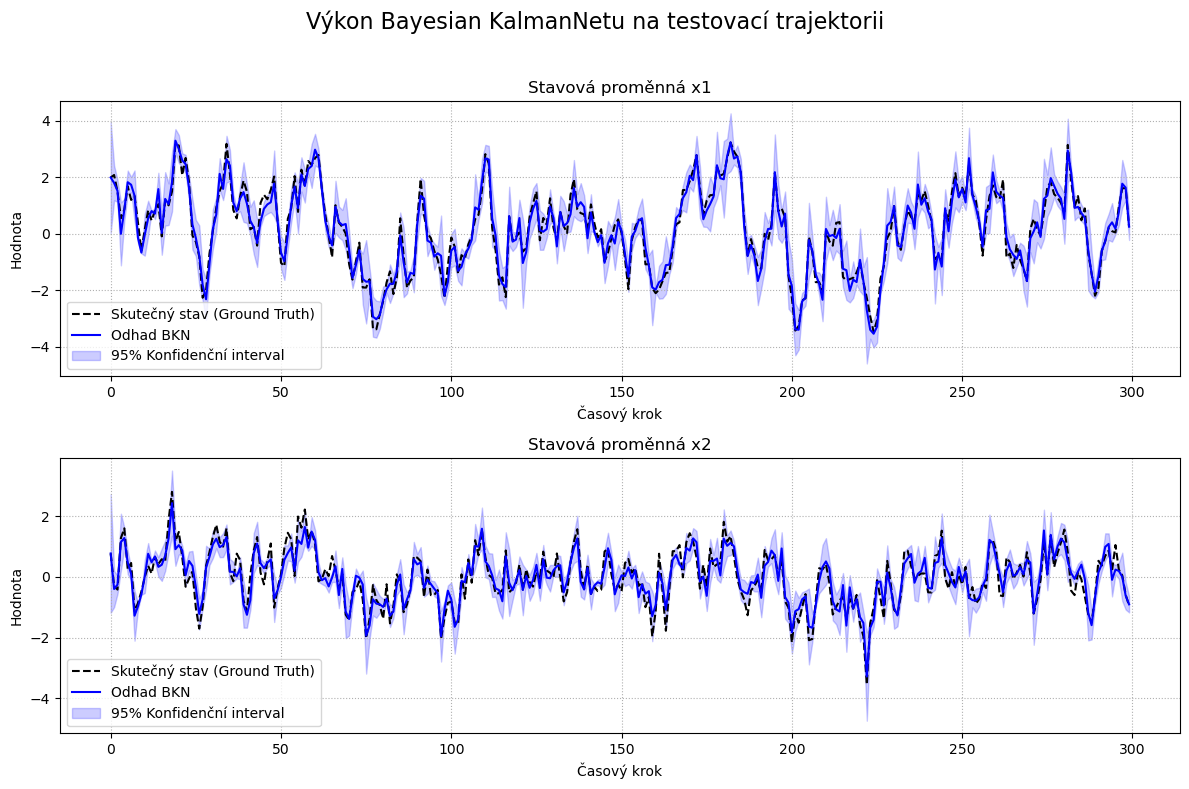

In [ ]:
import numpy as np

print("\nVykresluji výsledky pro první testovací trajektorii...")

# Získání dat pro první trajektorii
x_true_plot = all_x_true_cpu[0].numpy()
x_hat_plot = all_x_hat_knet_cpu[0].numpy()
P_hat_plot = all_P_hat_knet_cpu[0] # Ponecháme jako tenzor pro snadnější výpočty

# Výpočet směrodatné odchylky a 95% konfidenčního intervalu
# Směrodatná odchylka je odmocnina z variance (diagonála P)
std_dev = torch.sqrt(torch.diagonal(P_hat_plot, dim1=-2, dim2=-1)).numpy()
conf_interval = 1.96 * std_dev # 1.96 pro 95% interval
upper_bound = x_hat_plot + conf_interval
lower_bound = x_hat_plot - conf_interval

# Příprava časové osy
time_axis = np.arange(TEST_SEQ_LEN)
state_dim_plot = x_true_plot.shape[1]

# Vytvoření grafu
fig, axes = plt.subplots(state_dim_plot, 1, figsize=(12, 4 * state_dim_plot), squeeze=False)
fig.suptitle('Výkon Bayesian KalmanNetu na testovací trajektorii', fontsize=16)

for i in range(state_dim_plot):
    ax = axes[i, 0]
    # Vykreslení skutečného stavu
    ax.plot(time_axis, x_true_plot[:, i], 'k--', label='Skutečný stav (Ground Truth)')
    # Vykreslení odhadu modelu
    ax.plot(time_axis, x_hat_plot[:, i], 'b-', label='Odhad BKN')
    # Vykreslení konfidenčního intervalu
    ax.fill_between(time_axis, lower_bound[:, i], upper_bound[:, i], color='blue', alpha=0.2, label='95% Konfidenční interval')

    ax.set_title(f'Stavová proměnná x{i+1}')
    ax.set_xlabel('Časový krok')
    ax.set_ylabel('Hodnota')
    ax.legend()
    ax.grid(True, linestyle=':')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Upraví layout, aby se titulek nepřekrýval
plt.show()